# Scenario 2 — Modular experiment notebook

This notebook runs scenario 2 training pipeline. It uses the modular codebase: `src.config`, `src.data`, and `src.train`.
Use the CLI runner `run_experiment.py` for reproducible command-line runs; this notebook is mainly for quick debugging and visualization.

In [5]:
# Imports
import sys
import torch
import matplotlib.pyplot as plt
from pathlib import Path

# Add project root to path so we can import src modules
sys.path.append('../../../')

from src.config import load_config, set_seed
from src.data import get_dataloaders
from src.train import Trainer
from src.models import Regressor, FeatureExtractor, ActivityClassifier

# Notebook-friendly plotting
%matplotlib inline

In [6]:
# Load merged config (base + experiment) and optionally override small values here
base_cfg = "../../../configs/base.yaml"  # Fixed path relative to experiments/scenario2/notebooks/
exp_cfg = "../configs/scenario2.yaml"    # Config is now in experiment directory
opts = []  # e.g. [alpha=1.0]

cfg = load_config(base_cfg, exp_cfg, opts=opts)
set_seed(getattr(cfg, 'seed', None))
print('device:', cfg.device)
print('Loaded config from', exp_cfg)
print('dataset_name:', getattr(cfg, 'dataset_name', 'NOT_FOUND'))
print('data_dir:', getattr(cfg, 'data_dir', 'NOT_FOUND'))
print('train_subjects:', getattr(cfg, 'train_subjects', 'NOT_FOUND'))

device: mps
Loaded config from ../configs/scenario2.yaml
dataset_name: mmfit
data_dir: ../../../data/mm-fit/
train_subjects: ['w01', 'w02', 'w03', 'w04', 'w06', 'w07', 'w08', 'w16', 'w17', 'w18', 'w00', 'w05']


In [7]:
# Create dataloaders from factory
dls = get_dataloaders(cfg.dataset_name, cfg)  # expected keys: 'train','val','test'
print('Datasets sizes:', {k: len(v.dataset) for k, v in dls.items()})

Datasets sizes: {'train': 8400, 'val': 2800, 'test': 2800}


In [8]:
# Build models from src.models using cleaner config structure
device = getattr(cfg, 'torch_device', torch.device(cfg.device))

models = {
    'pose2imu': Regressor(
        in_ch=cfg.models.regressor.input_channels,
        num_joints=cfg.models.regressor.num_joints,
        window_length=cfg.models.regressor.sequence_length,
    ).to(device),
    'fe': FeatureExtractor().to(device),
    'ac': ActivityClassifier(
        f_in=cfg.models.classifier.f_in, 
        n_classes=cfg.models.classifier.n_classes
    ).to(device),
}

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)
print('param counts:', {k: count_params(m) for k, m in models.items()})

param counts: {'pose2imu': 4408836, 'fe': 68626, 'ac': 1111}


In [9]:
# Optimizer, scheduler and Trainer
# Convert lr to float if it's a string (YAML sometimes loads 1e-3 as string)
lr = float(cfg.lr) if isinstance(cfg.lr, str) else cfg.lr

params = sum([list(m.parameters()) for m in models.values()], [])
optimizer = torch.optim.Adam(params, lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=cfg.patience)

trainer = Trainer(models=models, dataloaders=dls, optimizer=optimizer, scheduler=scheduler, cfg=cfg, device=device)
print('Trainer instantiated')

Trainer instantiated


In [10]:
# ORIGINAL TRAINING CELL - Use this one, not the debug cell below
# Run training (for quick notebook tests, override epochs in cfg or pass a small number)
# For testing, you can use: history = trainer.fit(1)
# For full training, use: history = trainer.fit(cfg.epochs)
epochs_to_run = 5  # Change this to cfg.epochs for full training
history = trainer.fit(epochs_to_run)
print('Training finished. History keys:', list(history.keys()))

Starting training for 5 epochs...
----------------------------------------------------------------------
Epoch   1/5 | Train Loss: 0.9624 | Val Loss: 5.0663 | Train F1: 0.1897 | Val F1: 0.5527
    → New best Val F1: 0.5527
Epoch   1/5 | Train Loss: 0.9624 | Val Loss: 5.0663 | Train F1: 0.1897 | Val F1: 0.5527
    → New best Val F1: 0.5527
Epoch   2/5 | Train Loss: 0.3295 | Val Loss: 4.4051 | Train F1: 0.9864 | Val F1: 0.5096
Epoch   2/5 | Train Loss: 0.3295 | Val Loss: 4.4051 | Train F1: 0.9864 | Val F1: 0.5096
Epoch   3/5 | Train Loss: 0.2603 | Val Loss: 8.2558 | Train F1: 0.9877 | Val F1: 0.5256
Epoch   3/5 | Train Loss: 0.2603 | Val Loss: 8.2558 | Train F1: 0.9877 | Val F1: 0.5256
Epoch   4/5 | Train Loss: 0.2542 | Val Loss: 7.1137 | Train F1: 0.9917 | Val F1: 0.4488
Epoch   4/5 | Train Loss: 0.2542 | Val Loss: 7.1137 | Train F1: 0.9917 | Val F1: 0.4488
Epoch   5/5 | Train Loss: 0.1995 | Val Loss: 6.8094 | Train F1: 0.6611 | Val F1: 0.4627
-------------------------------------------

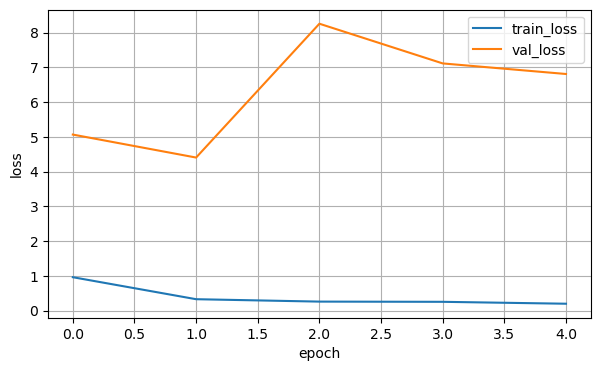

In [11]:
# Simple visualizations
plt.figure(figsize=(7,4))
if 'train_loss' in history and 'val_loss' in history:
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print('No loss history in trainer output')

Notes:
- This notebook follows the modular approach: it loads a merged config, builds dataloaders, models, and delegates training to `src.train.Trainer`.
- After you verify this notebook reproduces expected behaviour, delete or archive the old `legacy/scenario2_legacy.ipynb`.
- For reproducible CLI runs use: `python run_experiment.py --experiment scenario2 --config configs/scenario2.yaml --seed 42`.